In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import math
import numpy as np
from torch import nn
sys.path.append('..')
from pathlib import Path
from typing import Union
from erank.data import get_metadataset_class
from omegaconf import OmegaConf
from torch.utils import data
from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
from erank.data import get_metadataset_class
from erank.data.omniglotdataset import OmniglotDataset
from ml_utilities.data_utils import show_images, Normalizer
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify dataset directory etc.

In [2]:
data_dir = '/home/max/phd/data'
dataset_name = 'omniglot'
top_level_folders = [
    'images_background',  # original train data 
    'images_evaluation',  # original test data
]
dataset_split_toplevel_folders = {
    'train': 'images_background',
    'val': 'images_background',
    'test': 'images_evaluation'
}

## Check file directory

In [3]:
# check folders
dataset_dir = Path(data_dir) / dataset_name
toplevel_folders_disk = [d.stem for d in dataset_dir.iterdir() if d.is_dir()]
set(top_level_folders).issubset(set(toplevel_folders_disk))

True

In [4]:
# check num alphabets
background_alphabets = [a.stem for a in (dataset_dir/ 'images_background').iterdir()]
evaluation_alphabets = [a.stem for a in (dataset_dir/ 'images_evaluation').iterdir()]
len(background_alphabets), len(evaluation_alphabets)

(30, 20)

## Dataset initialization + data loading

In [5]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.60it/s]


In [6]:
# number of classes
classes = list(ogds._data.keys())
len(classes)

883

In [7]:
# shape of data stored in dataset
imgs = ogds._data[classes[0]]
imgs.shape

(20, 1, 28, 28)

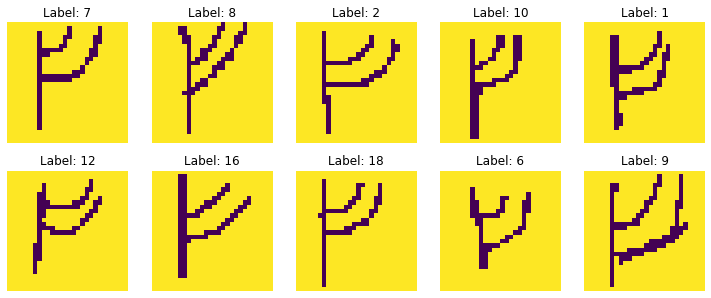

In [8]:
show_images(imgs, num_images=10, n_cols=5)

## Task generation

In [9]:
ogds.create_pregen_tasks()
for t in ogds.pregen_tasks:
    print(t.name)

Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07
Arcadian--character25#Armenian--character32#Hebrew--character03#N_Ko--character10#N_Ko--character20
Asomtavruli_(Georgian)--character27#Braille--character22#Japanese_(katakana)--character32#Korean--character20#Malay_(Jawi_-_Arabic)--character19
Bengali--character09#Grantha--character42#Korean--character11#Korean--character19#Mkhedruli_(Georgian)--character16
Braille--character12#Grantha--character31#Japanese_(katakana)--character32#Syriac_(Estrangelo)--character01#Syriac_(Estrangelo)--character04


In [10]:
# different seed -> must sample other tasks, same seed -> same tasks OK
ogds1 = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

ogds1.create_pregen_tasks()
for t in ogds1.pregen_tasks:
    print(t.name)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.86it/s]
Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07
Arcadian--character25#Armenian--character32#Hebrew--character03#N_Ko--character10#N_Ko--character20
Asomtavruli_(Georgian)--character27#Braille--character22#Japanese_(katakana)--character32#Korean--character20#Malay_(Jawi_-_Arabic)--character19
Bengali--character09#Grantha--character42#Korean--character11#Korean--character19#Mkhedruli_(Georgian)--character16
Braille--character12#Grantha--character31#Japanese_(katakana)--character32#Syriac_(Estrangelo)--character01#Syriac_(Estrangelo)--character04


In [11]:
ogds.get_tasks(num_tasks=1)[0].name, ogds1.get_tasks(num_tasks=1)[0].name

('Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07',
 'Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07')

## Task support and query set sampling

In [12]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
for task in ogds.get_tasks(num_tasks=5):
    print(task.name, len(task.support_set))

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.60it/s]
Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06 2
Arcadian--character18#Bengali--character02#Bengali--character28#Gujarati--character28#Latin--character08 2
Armenian--character03#Cyrillic--character05#Grantha--character12#Korean--character04#Latin--character01 2
Asomtavruli_(Georgian)--character38#Bengali--character06#Early_Aramaic--character01#Greek--character05#Japanese_(katakana)--character33 2
Cyrillic--character28#Futurama--character08#Latin--character13#Syriac_(Estrangelo)--character14#Tifinagh--character53 2


In [13]:
task = ogds.get_tasks(num_tasks=1)[0]
task.name, len(task.support_set)

('Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06',
 2)

In [14]:
x_, y_ = task.support_set
x_.shape, y_.shape

(torch.Size([25, 1, 28, 28]), torch.Size([25, 1]))

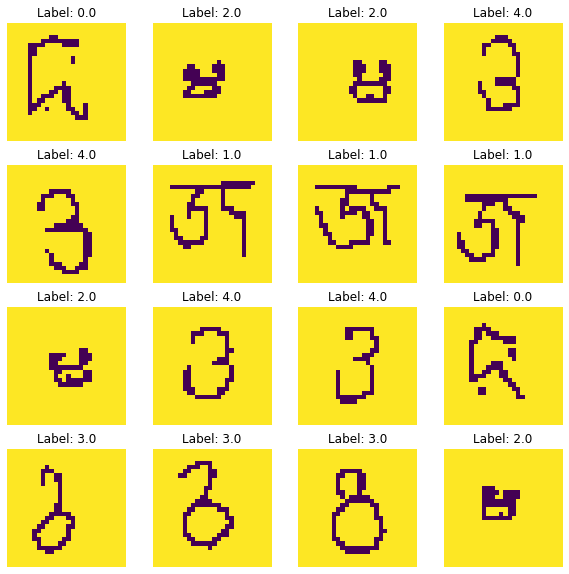

In [15]:
show_images((x_, y_), num_images=16)

In [16]:
task._support_idxes[task.task_classes[0]], task._query_idxes[task.task_classes[0]]

(array([19, 14, 11,  3,  2]), array([18,  7, 17, 16,  5,  8, 10, 15, 12,  6]))

In [17]:
for t_cls in task.task_classes:
    supp_idxes = task._support_idxes[t_cls]
    query_idxes = task._query_idxes[t_cls]
    intersect = np.intersect1d(supp_idxes, query_idxes)
    print(intersect)
    # assert len(intersect) == 0

[]
[]
[]
[]
[]


## Dataset Normalization

In [18]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0, 
                       normalizer=None)
normalizer_values = ogds.compute_normalizer()
normalizer_values

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.43it/s]


{'mean': [0.9213101208773438],
 'std': [0.2628733349463854],
 'num_dataset_samples': 17660}

In [19]:
tasks = ogds.sample_tasks(num_tasks=1)

In [20]:
task = tasks[0]
support_x = task.support_set[0]
task.name, support_x.shape, task.support_set[1].shape

('Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07',
 torch.Size([25, 1, 28, 28]),
 torch.Size([25, 1]))

In [21]:
normalizer = Normalizer(scaler_values=normalizer_values)
normalizer(support_x).shape

torch.Size([25, 1, 28, 28])

In [22]:
s = torch.randn(size=(5,1,28,28))
normalizer(s).shape

torch.Size([5, 1, 28, 28])

In [23]:
ogds2 = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
tasks = ogds2.sample_tasks(num_tasks=10000)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


In [24]:
ogds2.normalizer

Normalizer(mean=[0.9213101208773438], std=[0.2628733349463854])

In [25]:
# calculate mean and std of task support sets
# should have mean 0 and std 1
mean = 0. 
std = 0.
num_samples = 0
for task in tasks:
    support_x = task.support_set[0]
    data_ = support_x.view(len(support_x), 1, -1)
    mean += data_.mean(dim=2).sum(dim=0)
    std += data_.std(dim=2).sum(dim=0)
    num_samples += len(support_x)
mean /= num_samples
std /= num_samples
mean, std

(tensor([0.0004]), tensor([0.9998]))

## Use Dataloader for task loading

In [26]:
omniglot_cfg = f"""
data_root_path: {data_dir}
n_way_classification: 5
support_size: 5
query_size: 10
dataset_layout: metadataset
split: train
num_tasks: 1000
regenerate_task_support_set: True
regenerate_task_query_set: True
seed: 0
"""
omniglot_cfg = OmegaConf.create(omniglot_cfg)
omniglot_class = get_metadataset_class('omniglot')
omniglot_dataset = omniglot_class(**omniglot_cfg)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.23it/s]


In [27]:
dataloader = data.DataLoader(omniglot_dataset, batch_size=None, num_workers=4, persistent_workers=True)
episode_iter = iter(dataloader)

In [28]:
for i in range(5):
    task = next(episode_iter)
    print(task.name)

Arcadian--character18#Bengali--character02#Bengali--character28#Gujarati--character28#Latin--character08
Armenian--character07#Cyrillic--character17#Malay_(Jawi_-_Arabic)--character32#N_Ko--character10#Sanskrit--character39
Asomtavruli_(Georgian)--character26#Balinese--character11#Greek--character18#Gujarati--character27#Sanskrit--character38
Cyrillic--character31#Japanese_(hiragana)--character40#Mkhedruli_(Georgian)--character02#Sanskrit--character13#Tifinagh--character17
Balinese--character08#Cyrillic--character12#Early_Aramaic--character11#Mkhedruli_(Georgian)--character06#Tifinagh--character08


In [29]:
for i in range(3):
    task.support_set
    for class_name, idxes in task._support_idxes.items():
        print('{cn:40s}:{idxes}'.format(cn=class_name, idxes=idxes))
    print('--')

Balinese--character08                   :[11  5  8  9  7]
Cyrillic--character12                   :[ 8  9 16 12  7]
Early_Aramaic--character11              :[18  3 12 15 16]
Mkhedruli_(Georgian)--character06       :[16  0 18  5  8]
Tifinagh--character08                   :[ 3 14 17  7 19]
--
Balinese--character08                   :[ 8 13  5 15  7]
Cyrillic--character12                   :[9 3 7 8 6]
Early_Aramaic--character11              :[19 12  2 11  3]
Mkhedruli_(Georgian)--character06       :[ 0  1 12  6 16]
Tifinagh--character08                   :[14  5 10  7  3]
--
Balinese--character08                   :[ 6  5 16  8  9]
Cyrillic--character12                   :[13  6  9  3 12]
Early_Aramaic--character11              :[12  3 19 16 11]
Mkhedruli_(Georgian)--character06       :[ 0  1 12  8  6]
Tifinagh--character08                   :[19 18 13 17  7]
--


In [30]:
# Do it again to check reproducibility
omniglot_cfg = f"""
data_root_path: {data_dir}
n_way_classification: 5
support_size: 5
query_size: 10
dataset_layout: metadataset
split: train
num_tasks: 1000
regenerate_task_support_set: True
regenerate_task_query_set: True
seed: 10 #0
"""
omniglot_cfg = OmegaConf.create(omniglot_cfg)
omniglot_class = get_metadataset_class('omniglot')
omniglot_dataset = omniglot_class(**omniglot_cfg)

dataloader = data.DataLoader(omniglot_dataset, batch_size=None, num_workers=4, persistent_workers=True)
episode_iter = iter(dataloader)
print('')
for i in range(5):
    task = next(episode_iter)
    print(task.name)
print('')
for i in range(3):
    task.support_set
    for class_name, idxes in task._support_idxes.items():
        print('{cn:40s}:{idxes}'.format(cn=class_name, idxes=idxes))
    print('--')

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]

Futurama--character19#Korean--character27#Latin--character24#Sanskrit--character16#Tifinagh--character02
Armenian--character40#Balinese--character07#Cyrillic--character22#Grantha--character26#Mkhedruli_(Georgian)--character32
Asomtavruli_(Georgian)--character08#Cyrillic--character01#Grantha--character16#Gujarati--character16#Malay_(Jawi_-_Arabic)--character22
Asomtavruli_(Georgian)--character40#Braille--character11#Cyrillic--character28#Hebrew--character15#N_Ko--character27
Arcadian--character22#Grantha--character27#Japanese_(katakana)--character01#Japanese_(katakana)--character25#N_Ko--character22

Arcadian--character22                   :[ 4  9 18 15 14]
Grantha--character27                    :[13 18  7  3 11]
Japanese_(katakana)--character01        :[16  1  0 14 17]
Japanese_(katakana)--character25        :[ 7 19  4  3  2]
N_Ko--character22                       :[ 0 12  7  4  3]
--
Arcadian--character22  